In [1]:
%load_ext autoreload
%autoreload 2

import os
base_path = '/Users/satya/Documents/Github_Projects/neural-representation-sqw/'
os.chdir(base_path)

#from utils import *
from src.utils import * 
import pandas as pd


2023-03-20 21:35:48.876019: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
batch_size = 4096
max_iter = 1000
learning_rate = 0.005
n_repeat = 10
model = tf.keras.models.load_model('models/siren')

In [20]:
all_low_count_sqw_path2_woBG = np.load('data_low_count/low_count_data_woBG_path2.npy')
all_low_count_sqw_path3_woBG = np.load('data_low_count/low_count_data_woBG_path3.npy')

all_low_count_sqw_path2 = np.load('data_low_count/low_count_data_path2.npy')
all_low_count_sqw_path3 = np.load('data_low_count/low_count_data_path3.npy')


In [21]:
c_q_path2 = np.array(pd.read_csv('data_experimental/Qlist_path2_woBG.csv', header=None)).T
c_E_path2 = np.array(pd.read_csv('data_experimental/Elist_path2_woBG.csv', header=None)[0]).T

c_q_path3 = np.array(pd.read_csv('data_experimental/Qlist_path3_woBG.csv', header=None)).T
c_E_path3 = np.array(pd.read_csv('data_experimental/Elist_path3_woBG.csv', header=None)[0]).T
    
pred_iter = [] 

for i in tqdm(range(len(all_low_count_sqw_path2))):
    
    # Load data without background -- this is the data that is used for the optimization
    low_count_sqw_path2_woBG = all_low_count_sqw_path2_woBG[i]
    low_count_sqw_path3_woBG = all_low_count_sqw_path3_woBG[i]
    
    # Load data with background -- used to calcualte total number of neutrons across both slices
    low_count_sqw_path2 = all_low_count_sqw_path2[i]
    low_count_sqw_path3 = all_low_count_sqw_path3[i]
    total_neutrons = np.sum(low_count_sqw_path2) + np.sum(low_count_sqw_path3)
    
    # Convert data to coordinate format 
    test_x_path2, test_y_path2 = convert_low_count_data_to_coordinates(c_q_path2, c_E_path2, low_count_sqw_path2_woBG)
    test_x_path3, test_y_path3  =convert_low_count_data_to_coordinates(c_q_path3, c_E_path3, low_count_sqw_path3_woBG)
    
    test_x = tf.convert_to_tensor(np.vstack((test_x_path2, test_x_path3[test_y_path3 != 0])), dtype=tf.float32) # exclude missing slice 
    test_y = tf.convert_to_tensor(np.concatenate((test_y_path2, test_y_path3[test_y_path3 != 0])), dtype=tf.float32)
    
    # Repeat multiple times and return the solution with the minimal loss 
    metrics_n_repeat = []
    for _ in range(n_repeat):
        min_loss, min_loss_j1, min_loss_j2, metrics  = optimize_surrogate(test_x, test_y, model, learning_rate = learning_rate, batch_size = batch_size, max_iter=max_iter, plotting=False)
        metrics_n_repeat.append([min_loss, min_loss_j1, min_loss_j2])
        
    metrics_n_repeat = np.array(metrics_n_repeat)
    lowest_loss_prediction_index = np.argmin(metrics_n_repeat[:,0])    
    lowest_loss_prediction = metrics_n_repeat[lowest_loss_prediction_index]
    
    j1_pred = lowest_loss_prediction[1]
    j2_pred = lowest_loss_prediction[2]
    
    j, jp = unnormalize_j1_j2(j1_pred,j2_pred)

    pred_iter.append([total_neutrons, j, jp])
    
    print(pred_iter[i])
        
pred_iter = np.array(pred_iter)         

  7%|▋         | 1/15 [06:09<1:26:13, 369.53s/it]

[789.0, 30.646847635507584, -11.609688997268677]


 13%|█▎        | 2/15 [12:19<1:20:06, 369.75s/it]

[1594.0, 35.90136170387268, -12.797354459762573]


 20%|██        | 3/15 [18:26<1:13:43, 368.59s/it]

[4107.0, 26.804622001945972, -6.18746280670166]


 27%|██▋       | 4/15 [24:44<1:08:15, 372.32s/it]

[8366.0, 20.0, -13.419139385223389]


 33%|███▎      | 5/15 [30:49<1:01:36, 369.68s/it]

[12191.0, 32.36202351748943, -3.4488821029663086]


 40%|████      | 6/15 [36:48<54:54, 366.10s/it]  

[16173.0, 29.70069393515587, 1.7663073539733887]


 47%|████▋     | 7/15 [42:48<48:31, 363.90s/it]

[18805.0, 29.856451228260994, 1.8281865119934082]


 53%|█████▎    | 8/15 [48:47<42:17, 362.54s/it]

[40839.0, 29.960933327674866, 1.7723989486694336]


 60%|██████    | 9/15 [54:46<36:08, 361.41s/it]

[57237.0, 29.589743837714195, 1.6698980331420898]


 67%|██████▋   | 10/15 [1:00:46<30:04, 360.82s/it]

[81499.0, 29.837186560034752, 1.9293427467346191]


 73%|███████▎  | 11/15 [1:06:13<23:21, 350.45s/it]

[122765.0, 29.798035994172096, 1.7876291275024414]


 80%|████████  | 12/15 [1:11:15<16:47, 335.73s/it]

[163521.0, 29.75237973034382, 1.7315888404846191]


 87%|████████▋ | 13/15 [9:14:32<5:00:36, 9018.35s/it]

[246024.0, 29.40505102276802, 1.628580093383789]


 93%|█████████▎| 14/15 [9:23:59<1:47:45, 6465.66s/it]

[326952.0, 29.72976714372635, 1.6075634956359863]


100%|██████████| 15/15 [9:36:34<00:00, 2306.31s/it]  

[819863.0, 29.511187821626663, 1.6191720962524414]


In [22]:
pred_iter

array([[ 7.89000000e+02,  3.06468476e+01, -1.16096890e+01],
       [ 1.59400000e+03,  3.59013617e+01, -1.27973545e+01],
       [ 4.10700000e+03,  2.68046220e+01, -6.18746281e+00],
       [ 8.36600000e+03,  2.00000000e+01, -1.34191394e+01],
       [ 1.21910000e+04,  3.23620235e+01, -3.44888210e+00],
       [ 1.61730000e+04,  2.97006939e+01,  1.76630735e+00],
       [ 1.88050000e+04,  2.98564512e+01,  1.82818651e+00],
       [ 4.08390000e+04,  2.99609333e+01,  1.77239895e+00],
       [ 5.72370000e+04,  2.95897438e+01,  1.66989803e+00],
       [ 8.14990000e+04,  2.98371866e+01,  1.92934275e+00],
       [ 1.22765000e+05,  2.97980360e+01,  1.78762913e+00],
       [ 1.63521000e+05,  2.97523797e+01,  1.73158884e+00],
       [ 2.46024000e+05,  2.94050510e+01,  1.62858009e+00],
       [ 3.26952000e+05,  2.97297671e+01,  1.60756350e+00],
       [ 8.19863000e+05,  2.95111878e+01,  1.61917210e+00]])

In [23]:
np.save('figures/data_for_figures/low_count_predictions', pred_iter)

In [11]:
pred_iter = np.load('figures/data_for_figures/low_count_predictions.npy')

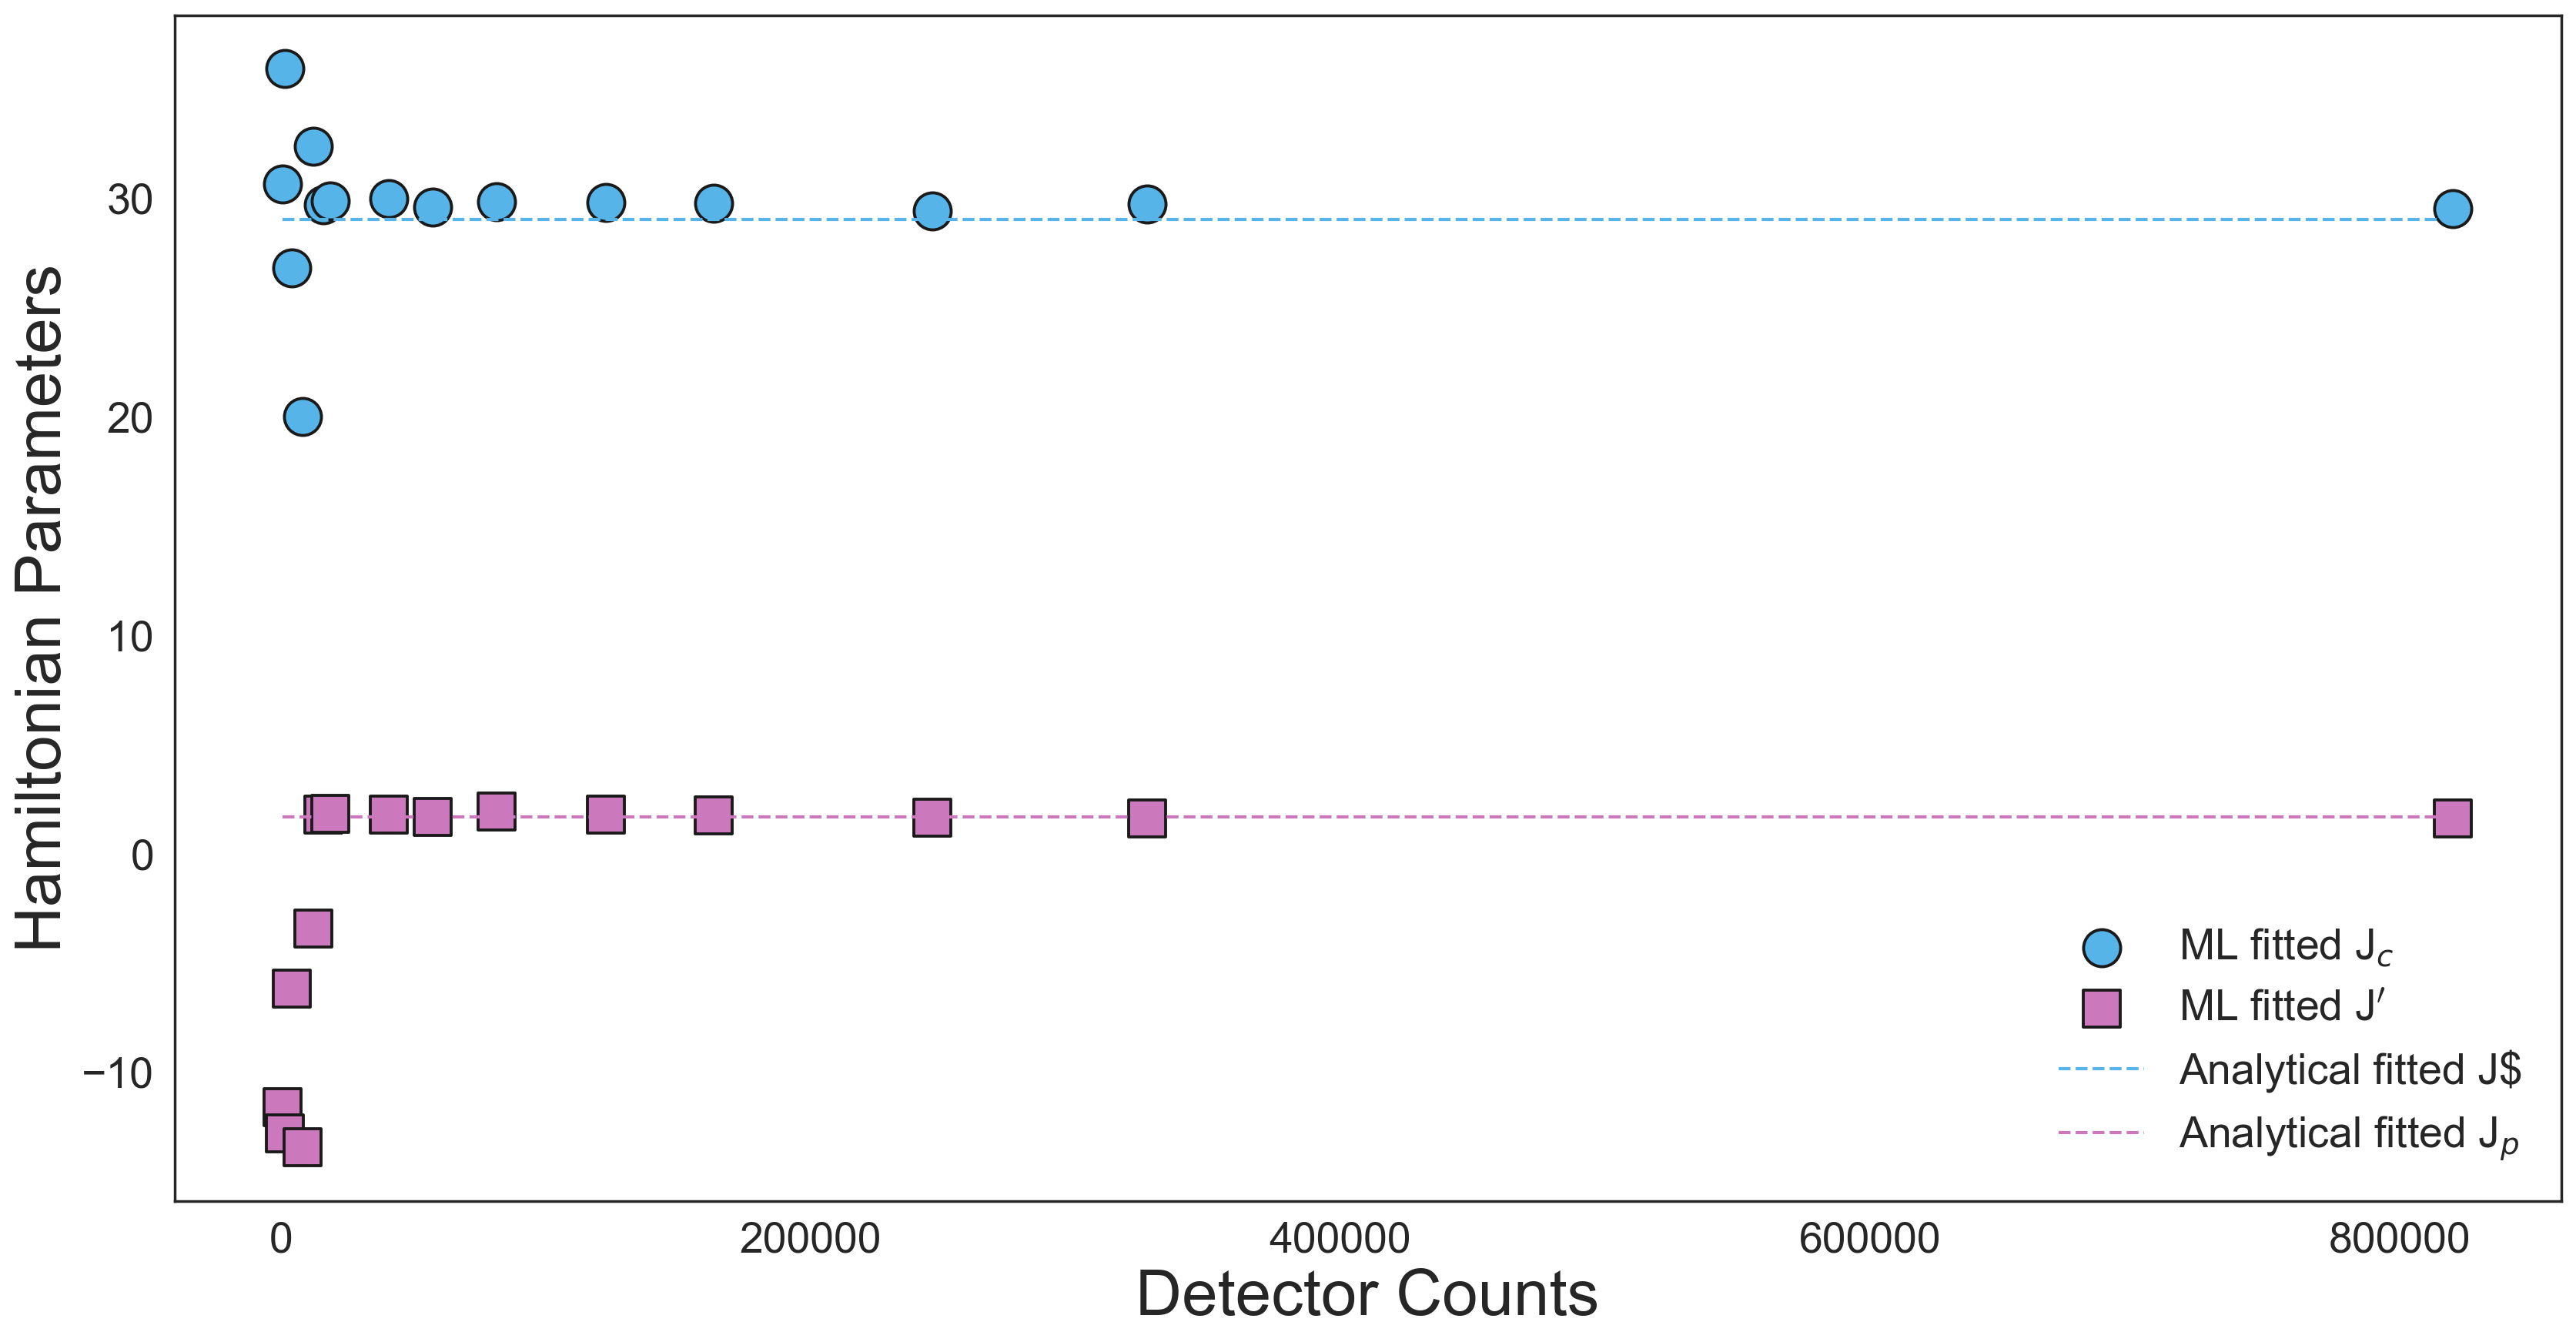

In [24]:
import seaborn as sns
sns.set_theme(style="white")
palette = sns.color_palette("colorblind")

plt.figure(figsize=(20, 10), dpi=200)
c1 = palette[9]
c2 = palette[4]

sns.scatterplot(x=pred_iter[:,0], y=pred_iter[:,1], color=c1, s=300,marker='o', edgecolor='k', label=r'ML fitted J$_c$')
sns.scatterplot(x=pred_iter[:,0], y=pred_iter[:,2], color=c2, s=300, marker='s', edgecolor='k', label = "ML fitted J$'$")
plt.plot(pred_iter[:,0], 29.008*np.ones(pred_iter[:,0].shape), "--", label=r'Analytical fitted J$', color = c1)
plt.plot(pred_iter[:,0], 1.675*np.ones(pred_iter[:,0].shape), "--", label = "Analytical fitted J$_p$",  color = c2)
plt.xlabel('Detector Counts', fontsize = 30)
plt.ylabel('Hamiltonian Parameters', fontsize = 30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
leg = plt.legend(fontsize=20)
leg.get_frame().set_visible(False) #
plt.show()